In [13]:
# Import necessary libraries
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load CSV files
train_labels = pd.read_csv('/content/sample_data/trainLabels.csv')
print("First 10 rows of the trainLabels dataset:")
display(train_labels.head(10))

sample_submission = pd.read_csv('/content/sample_data/sampleSubmission.csv')
print("First 10 rows of the sampleSubmission dataset:")
display(sample_submission.head(10))


First 10 rows of the trainLabels dataset:


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


First 10 rows of the sampleSubmission dataset:


,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
5,6,cat
6,7,cat
7,8,cat
8,9,cat
9,10,cat


In [14]:
# Set device to CPU (using CPU-only for memory efficiency)
dev = torch.device("cpu")

# Define transformations with CIFAR-10's original image resolution (32x32)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Set to 32x32 to match CIFAR-10's original resolution
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset and use subsets for initial testing
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a smaller subset of the dataset to reduce memory load
subset_train = torch.utils.data.Subset(train_set, range(3000))  # 3,000 training samples
subset_test = torch.utils.data.Subset(test_set, range(500))  # 500 test samples
train_loader = DataLoader(subset_train, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(subset_test, batch_size=32, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Define a helper function to train and evaluate each model, and track metrics
def train_and_evaluate(model, model_name, train_loader, test_loader, epochs=25):
    cri = nn.CrossEntropyLoss()
    opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    # Lists to store metrics
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(dev), labels.to(dev)
            opt.zero_grad()
            outputs = model(images)
            loss = cri(outputs, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        # Calculate average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop to calculate accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(dev), labels.to(dev)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"{model_name} - Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_accuracies


In [16]:
from torchvision import models

# Define ResNet-18 model
model_name = 'ResNet-18'
model_resnet = models.resnet18(pretrained=True)


for param in model_resnet.parameters():
    param.requires_grad = False

# Modify the final layer for CIFAR-10's 10 classes
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)
model_resnet = model_resnet.to(dev)

# Train and evaluate ResNet-18 with 25 epochs
print(f"\nTraining and Evaluating {model_name} on the Dataset provided")
train_losses_resnet, val_accuracies_resnet = train_and_evaluate(model_resnet, model_name, train_loader, test_loader, epochs=25)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training and Evaluating ResNet-18 on the Dataset provided
ResNet-18 - Epoch 1/25, Train Loss: 2.1438, Validation Accuracy: 36.80%
ResNet-18 - Epoch 2/25, Train Loss: 1.7979, Validation Accuracy: 40.20%
ResNet-18 - Epoch 3/25, Train Loss: 1.6783, Validation Accuracy: 42.40%
ResNet-18 - Epoch 4/25, Train Loss: 1.6094, Validation Accuracy: 43.60%
ResNet-18 - Epoch 5/25, Train Loss: 1.5861, Validation Accuracy: 43.20%
ResNet-18 - Epoch 6/25, Train Loss: 1.5637, Validation Accuracy: 42.80%
ResNet-18 - Epoch 7/25, Train Loss: 1.5210, Validation Accuracy: 40.60%
ResNet-18 - Epoch 8/25, Train Loss: 1.5071, Validation Accuracy: 41.00%
ResNet-18 - Epoch 9/25, Train Loss: 1.4826, Validation Accuracy: 43.60%
ResNet-18 - Epoch 10/25, Train Loss: 1.4749, Validation Accuracy: 42.80%
ResNet-18 - Epoch 11/25, Train Loss: 1.4509, Validation Accuracy: 44.00%
ResNet-18 - Epoch 12/25, Train Loss: 1.4567, Validation Accuracy: 44.20%
ResNet-18 - Epoch 13/25, Train Loss: 1.4561, Validation Accuracy: 42.00%
R

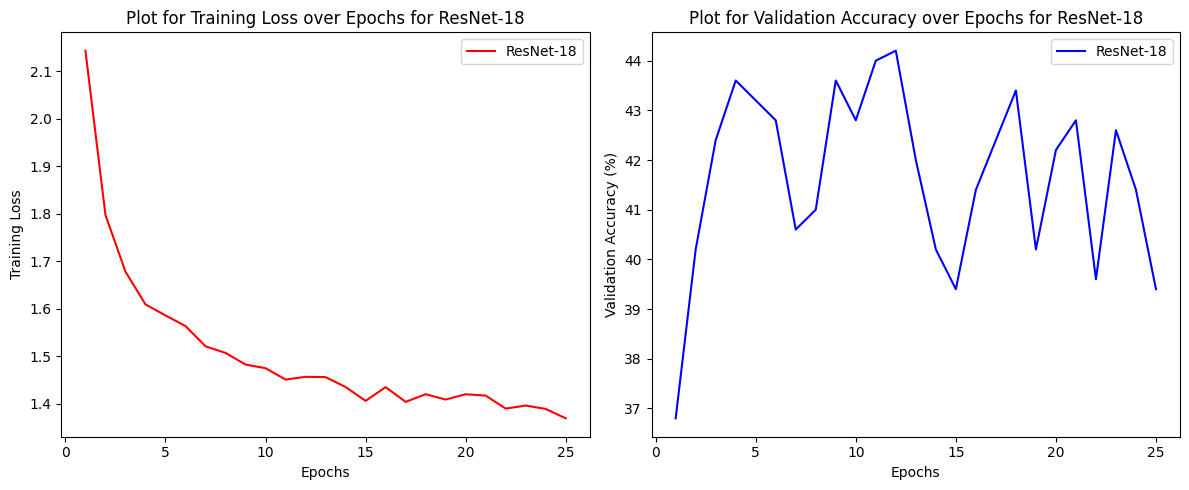

In [17]:
plt.figure(figsize=(12, 5))

# Training Loss Plot for ResNet-18
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_resnet) + 1), train_losses_resnet, label='ResNet-18', color='red')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot for Training Loss over Epochs for ResNet-18')
plt.legend()

# Validation Accuracy Plot for ResNet-18
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_resnet) + 1), val_accuracies_resnet, label='ResNet-18', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Plot for Validation Accuracy over Epochs for ResNet-18')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Define VGG-16 model
model_name = 'VGG-16'
model_vgg = models.vgg16(pretrained=True)

for param in model_vgg.parameters():
    param.requires_grad = False

# Modify the final layer for CIFAR-10's 10 classes
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, 10)
model_vgg = model_vgg.to(dev)

# Train and evaluate VGG-16 with 25 epochs
print(f"\nTraining and Evaluating {model_name} on the Dataset provided")
train_losses_vgg, val_accuracies_vgg = train_and_evaluate(model_vgg, model_name, train_loader, test_loader, epochs=25)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.3MB/s]



Training and Evaluating VGG-16 on the Dataset provided
VGG-16 - Epoch 1/25, Train Loss: 1.6088, Validation Accuracy: 55.00%
VGG-16 - Epoch 2/25, Train Loss: 1.2339, Validation Accuracy: 55.40%
VGG-16 - Epoch 3/25, Train Loss: 1.1100, Validation Accuracy: 54.00%
VGG-16 - Epoch 4/25, Train Loss: 1.0089, Validation Accuracy: 55.20%
VGG-16 - Epoch 5/25, Train Loss: 0.9801, Validation Accuracy: 55.20%
VGG-16 - Epoch 6/25, Train Loss: 0.9565, Validation Accuracy: 54.80%
VGG-16 - Epoch 7/25, Train Loss: 0.9251, Validation Accuracy: 55.40%
VGG-16 - Epoch 8/25, Train Loss: 0.8870, Validation Accuracy: 54.20%
VGG-16 - Epoch 9/25, Train Loss: 0.8472, Validation Accuracy: 55.20%
VGG-16 - Epoch 10/25, Train Loss: 0.8566, Validation Accuracy: 53.80%
VGG-16 - Epoch 11/25, Train Loss: 0.8746, Validation Accuracy: 54.40%
VGG-16 - Epoch 12/25, Train Loss: 0.8242, Validation Accuracy: 54.00%
VGG-16 - Epoch 13/25, Train Loss: 0.8404, Validation Accuracy: 53.40%
VGG-16 - Epoch 14/25, Train Loss: 0.8156, V

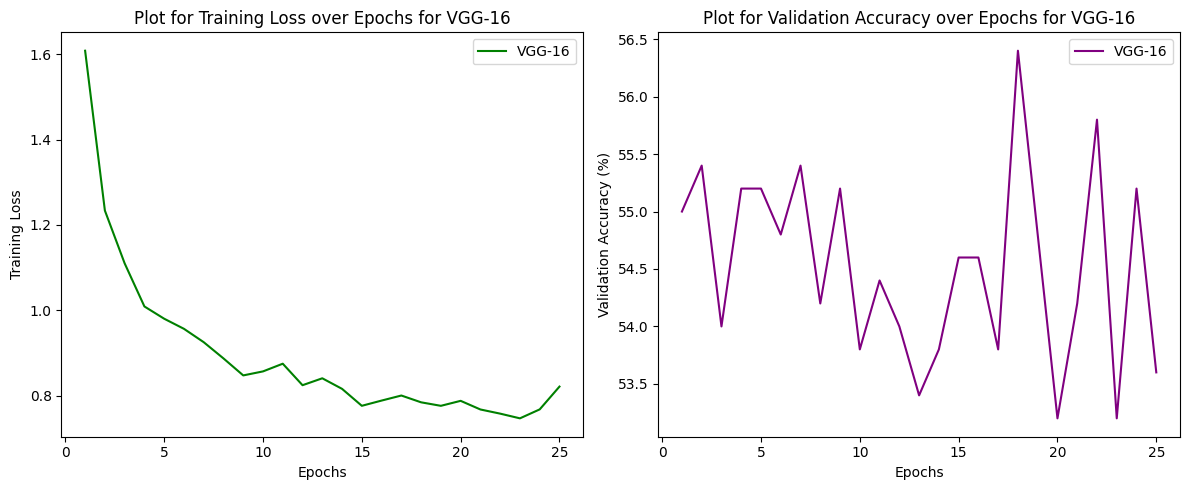

In [19]:
# Plot training loss and validation accuracy for VGG-16
plt.figure(figsize=(12, 5))

# Training Loss Plot for VGG-16
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_vgg) + 1), train_losses_vgg, label='VGG-16', color='green')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot for Training Loss over Epochs for VGG-16')
plt.legend()

# Validation Accuracy Plot for VGG-16
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_vgg) + 1), val_accuracies_vgg, label='VGG-16', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Plot for Validation Accuracy over Epochs for VGG-16')
plt.legend()

plt.tight_layout()
plt.show()



In [20]:
# Define MobileNetV2 model
model_name = 'MobileNetV2'
model_mobilenet = models.mobilenet_v2(pretrained=True)


for param in model_mobilenet.parameters():
    param.requires_grad = False

# Modify the final layer for CIFAR-10's 10 classes
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 10)
model_mobilenet = model_mobilenet.to(dev)

# Train and evaluate MobileNetV2 with 25 epochs
print(f"\nTraining and Evaluating {model_name} on the Dataset provided")
train_losses_mobilenet, val_accuracies_mobilenet = train_and_evaluate(model_mobilenet, model_name, train_loader, test_loader, epochs=25)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 90.6MB/s]


Training and Evaluating MobileNetV2 on the Dataset provided


MobileNetV2 - Epoch 1/25, Train Loss: 2.0977, Validation Accuracy: 33.60%
MobileNetV2 - Epoch 2/25, Train Loss: 1.7983, Validation Accuracy: 36.00%
MobileNetV2 - Epoch 3/25, Train Loss: 1.7542, Validation Accuracy: 36.60%
MobileNetV2 - Epoch 4/25, Train Loss: 1.7112, Validation Accuracy: 39.40%
MobileNetV2 - Epoch 5/25, Train Loss: 1.6620, Validation Accuracy: 39.20%
MobileNetV2 - Epoch 6/25, Train Loss: 1.6712, Validation Accuracy: 39.40%
MobileNetV2 - Epoch 7/25, Train Loss: 1.6451, Validation Accuracy: 37.60%
MobileNetV2 - Epoch 8/25, Train Loss: 1.6292, Validation Accuracy: 39.40%
MobileNetV2 - Epoch 9/25, Train Loss: 1.5871, Validation Accuracy: 41.40%
MobileNetV2 - Epoch 10/25, Train Loss: 1.6112, Validation Accuracy: 40.00%
MobileNetV2 - Epoch 11/25, Train Loss: 1.6488, Validation Accuracy: 39.40%
MobileNetV2 - Epoch 12/25, Train Loss: 1.6219, Validation Accuracy: 38.20%
MobileNetV2 - Epoch 13/25, Train Loss: 1.6083, Validation Accuracy: 40.60%
MobileNetV2 - Epoch 14/25, Train L

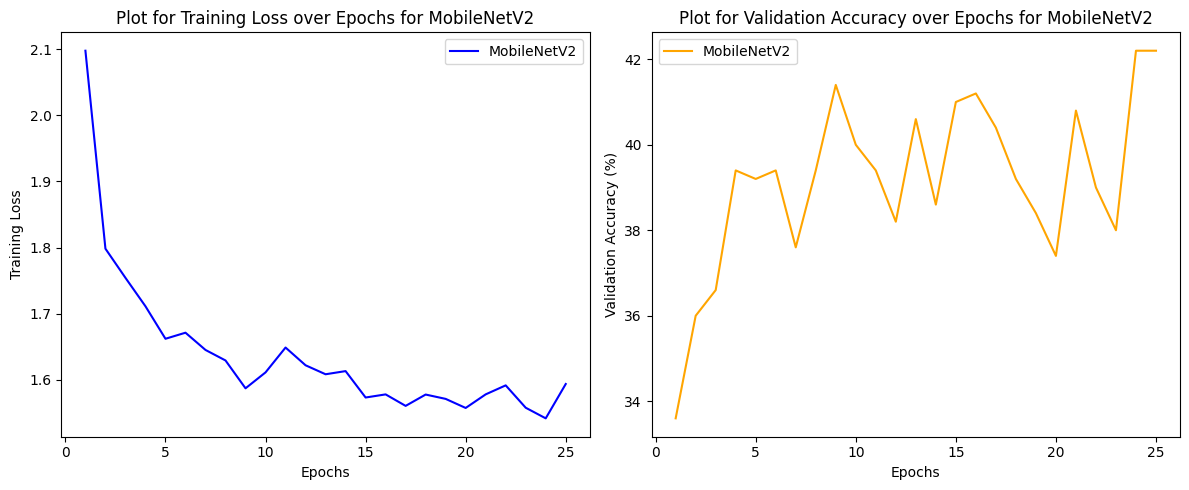

In [21]:
# Plot training loss and validation accuracy for MobileNetV2
plt.figure(figsize=(12, 5))

# Training Loss Plot for MobileNetV2
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_mobilenet) + 1), train_losses_mobilenet, label='MobileNetV2', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot for Training Loss over Epochs for MobileNetV2')
plt.legend()

# Validation Accuracy Plot for MobileNetV2
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_mobilenet) + 1), val_accuracies_mobilenet, label='MobileNetV2', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Plot for Validation Accuracy over Epochs for MobileNetV2')
plt.legend()

plt.tight_layout()
plt.show()
